In [84]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

# 设置设备：优先使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 存储所有实验结果用于对比
results = {}

Using device: cuda


In [85]:
blood_mnist = np.load("dataset/bloodmnist.npz")
organc_mnist = np.load("dataset/organcmnist.npz")

num_epochs = 10

In [86]:
blood_mnist["train_images"].shape, blood_mnist["val_images"].shape, blood_mnist["test_images"].shape

((11959, 28, 28, 3), (1712, 28, 28, 3), (3421, 28, 28, 3))

In [87]:
organc_mnist["train_images"].shape, organc_mnist["val_images"].shape, organc_mnist["test_images"].shape

((12975, 28, 28), (2392, 28, 28), (8216, 28, 28))

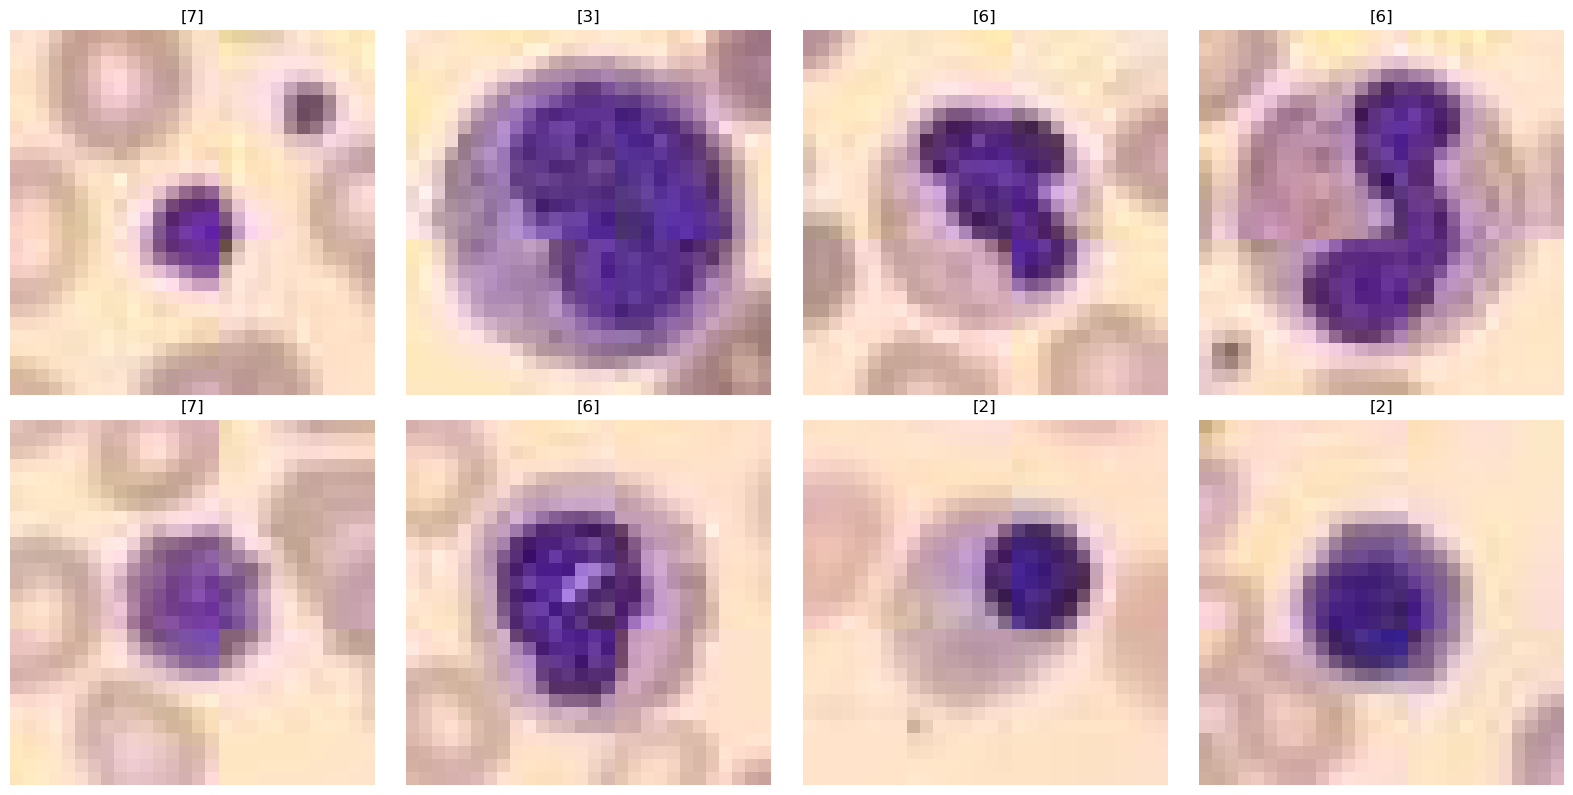

In [88]:
# 8 classes intotal

fig, axs = plt.subplots(2,4, figsize=(16,8))
axs = axs.flatten()

images = blood_mnist["train_images"][:8]
labels = blood_mnist["train_labels"][:8]

for ax, image, label in zip(axs, images, labels):
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(label, fontsize=12)

plt.tight_layout()
plt.show()

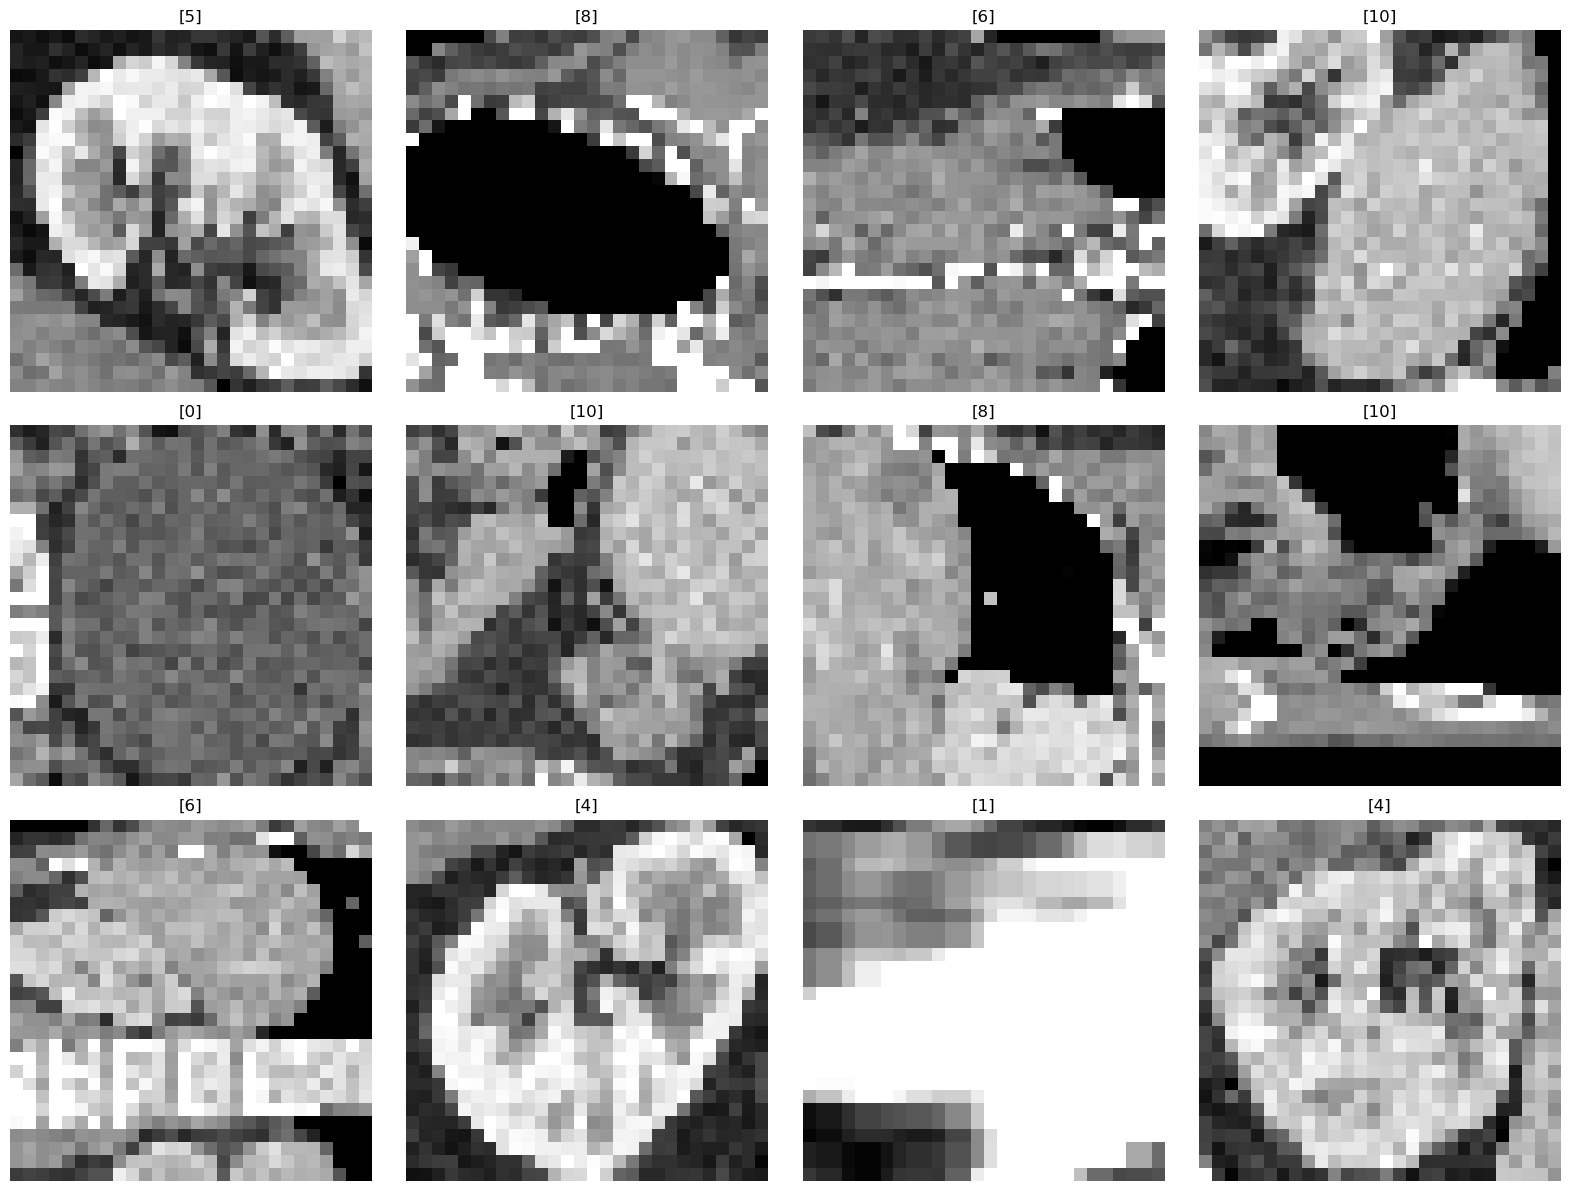

In [89]:
# 11 classes intotal

fig, axs = plt.subplots(3,4, figsize=(16,12))
axs = axs.flatten()

images = organc_mnist["train_images"][:12]
labels = organc_mnist["train_labels"][:12]

for ax, image, label in zip(axs, images, labels):
    ax.imshow(image, cmap="gray")
    ax.axis("off")
    ax.set_title(label, fontsize=12)

plt.tight_layout()
plt.show()

# BloodMNIST 28

In [90]:
class bloodDataset(Dataset):
    def __init__(self, labels, images, transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx][0]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [91]:
train_ds, val_ds, test_ds = [bloodDataset(blood_mnist[split+"_labels"], blood_mnist[split+"_images"], transform=transforms.ToTensor()) for split in ["train", "val", "test"]]

In [92]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [93]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Flatten(),
    nn.Linear(64*7*7, 128),
    nn.ReLU(),
    nn.Linear(128, 8)
).to(device)  # 将模型移到GPU

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# num_epochs = 10

In [95]:
# 记录损失用于可视化
train_losses_blood28 = []
val_losses_blood28 = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses_blood28.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    val_loss /= len(val_loader)
    val_losses_blood28.append(val_loss)

    print(f"[{epoch+1}/{num_epochs}] train_loss: {train_loss:.6f} | val_loss: {val_loss:.6f}")

[1/10] train_loss: 1.038984 | val_loss: 0.639024
[2/10] train_loss: 0.581870 | val_loss: 0.472985
[3/10] train_loss: 0.467994 | val_loss: 0.418594
[4/10] train_loss: 0.403803 | val_loss: 0.389202
[5/10] train_loss: 0.368739 | val_loss: 0.449228
[6/10] train_loss: 0.331687 | val_loss: 0.370915
[7/10] train_loss: 0.304382 | val_loss: 0.347077
[8/10] train_loss: 0.290565 | val_loss: 0.322446
[9/10] train_loss: 0.268777 | val_loss: 0.277969
[10/10] train_loss: 0.248359 | val_loss: 0.287742


In [96]:
# 测试并收集预测概率用于AUC计算
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
all_labels_array = np.array(all_labels)

In [97]:
f1 = f1_score(all_labels, all_preds, average="macro")
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test F1 score: {f1:.6f}")

Test F1 score: 0.872081


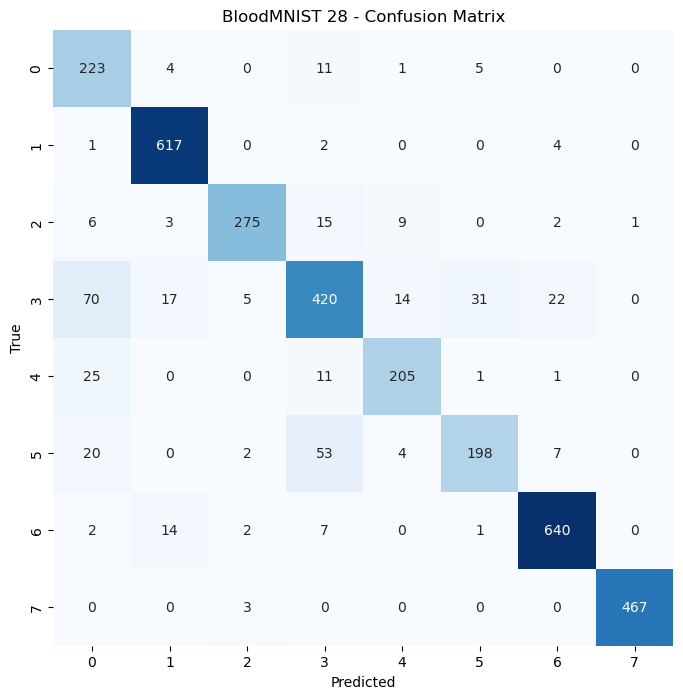

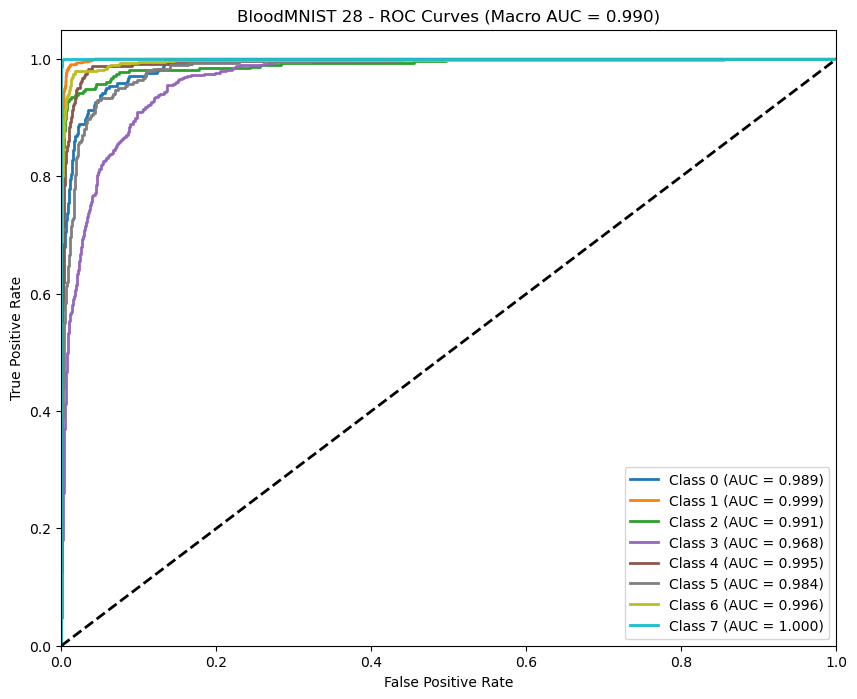

In [98]:
# 混淆矩阵
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, cmap="Blues", annot=True, cbar=False, fmt="d")
plt.title("BloodMNIST 28 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 计算并绘制ROC曲线和AUC
n_classes = 8
labels_bin = label_binarize(all_labels_array, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算宏平均AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc_blood28 = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'BloodMNIST 28 - ROC Curves (Macro AUC = {macro_auc_blood28:.3f})')
plt.legend(loc="lower right")
plt.show()

# 保存结果
results['blood28'] = {
    'train_losses': train_losses_blood28,
    'val_losses': val_losses_blood28,
    'macro_auc': macro_auc_blood28,
    'fpr': all_fpr,
    'tpr': mean_tpr,
    'f1': f1
}

# OrgancMNIST 28

In [99]:
# it's the same as bloodDataset class
class organcDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx][0]

        if self.transform:
            image = self.transform(image)

        return image, label

In [100]:
train_ds, val_ds, test_ds = [organcDataset(organc_mnist[split+"_images"], organc_mnist[split+"_labels"], transform=transforms.ToTensor()) for split in ["train", "val", "test"]]

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [101]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(64*7*7, 128),
    nn.ReLU(),
    nn.Linear(128, 11)
).to(device)

In [102]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# num_epochs = 10

In [103]:
# 记录损失用于可视化
train_losses_organc28 = []
val_losses_organc28 = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    train_losses_organc28.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses_organc28.append(val_loss)

    print(f"[{epoch+1}/{num_epochs}] | train_loss: {train_loss:.6f} | val_loss: {val_loss:.6f}")

[1/10] | train_loss: 0.765884 | val_loss: 0.228150
[2/10] | train_loss: 0.313324 | val_loss: 0.212785
[3/10] | train_loss: 0.200252 | val_loss: 0.186080
[4/10] | train_loss: 0.147124 | val_loss: 0.235940
[5/10] | train_loss: 0.111247 | val_loss: 0.178019
[6/10] | train_loss: 0.085846 | val_loss: 0.216943
[7/10] | train_loss: 0.070504 | val_loss: 0.198431
[8/10] | train_loss: 0.057623 | val_loss: 0.226053
[9/10] | train_loss: 0.043843 | val_loss: 0.250673
[10/10] | train_loss: 0.033454 | val_loss: 0.251351


In [104]:
# 测试并收集预测概率用于AUC计算
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
all_labels_array = np.array(all_labels)

In [105]:
f1 = f1_score(all_labels, all_preds, average="macro")
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f"Test F1 score: {f1:.6f}")

Test F1 score: 0.867104


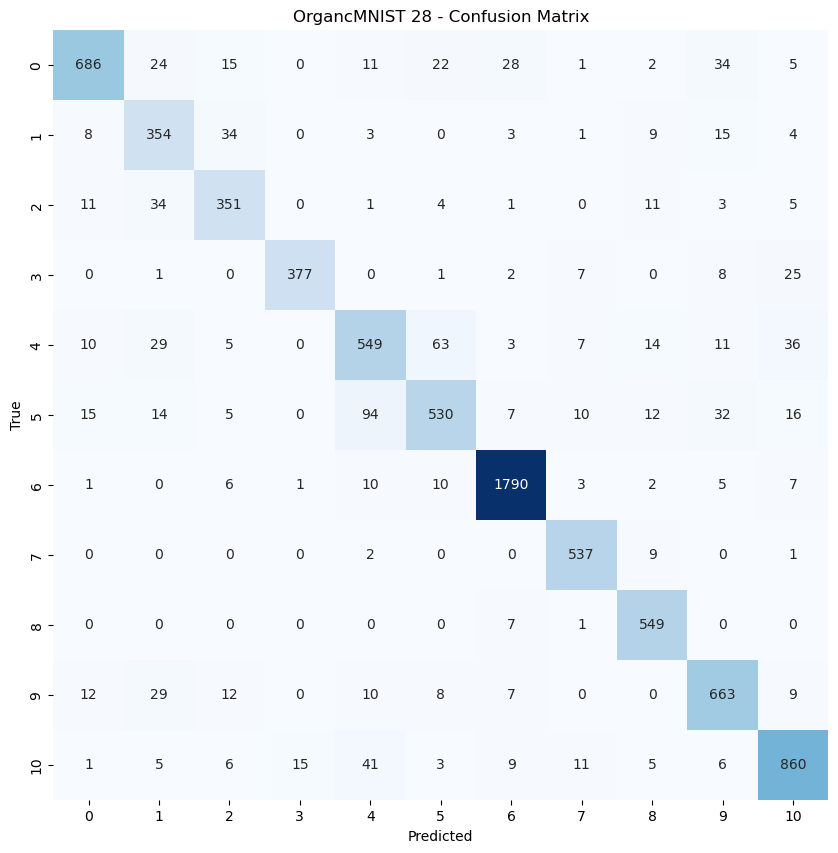

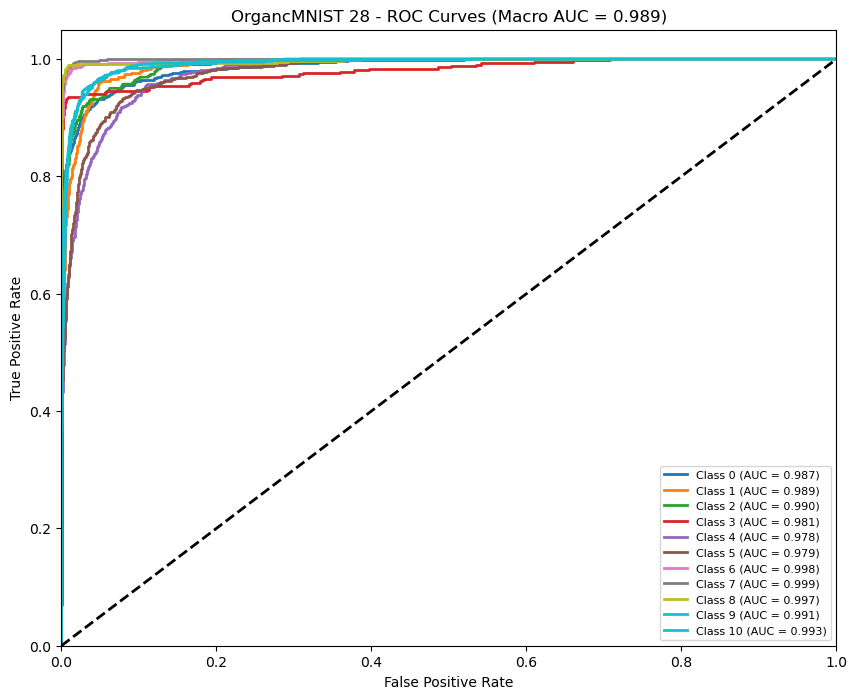

In [106]:
# 混淆矩阵
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("OrgancMNIST 28 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 计算并绘制ROC曲线和AUC
n_classes = 11
labels_bin = label_binarize(all_labels_array, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算宏平均AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc_organc28 = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'OrgancMNIST 28 - ROC Curves (Macro AUC = {macro_auc_organc28:.3f})')
plt.legend(loc="lower right", fontsize=8)
plt.show()

# 保存结果
results['organc28'] = {
    'train_losses': train_losses_organc28,
    'val_losses': val_losses_organc28,
    'macro_auc': macro_auc_organc28,
    'fpr': all_fpr,
    'tpr': mean_tpr,
    'f1': f1
}

# BloodMNIST 64

In [107]:
blood_mnist64 = np.load("dataset/bloodmnist_64.npz")
organc_mnist64 = np.load("dataset/organcmnist_64.npz")

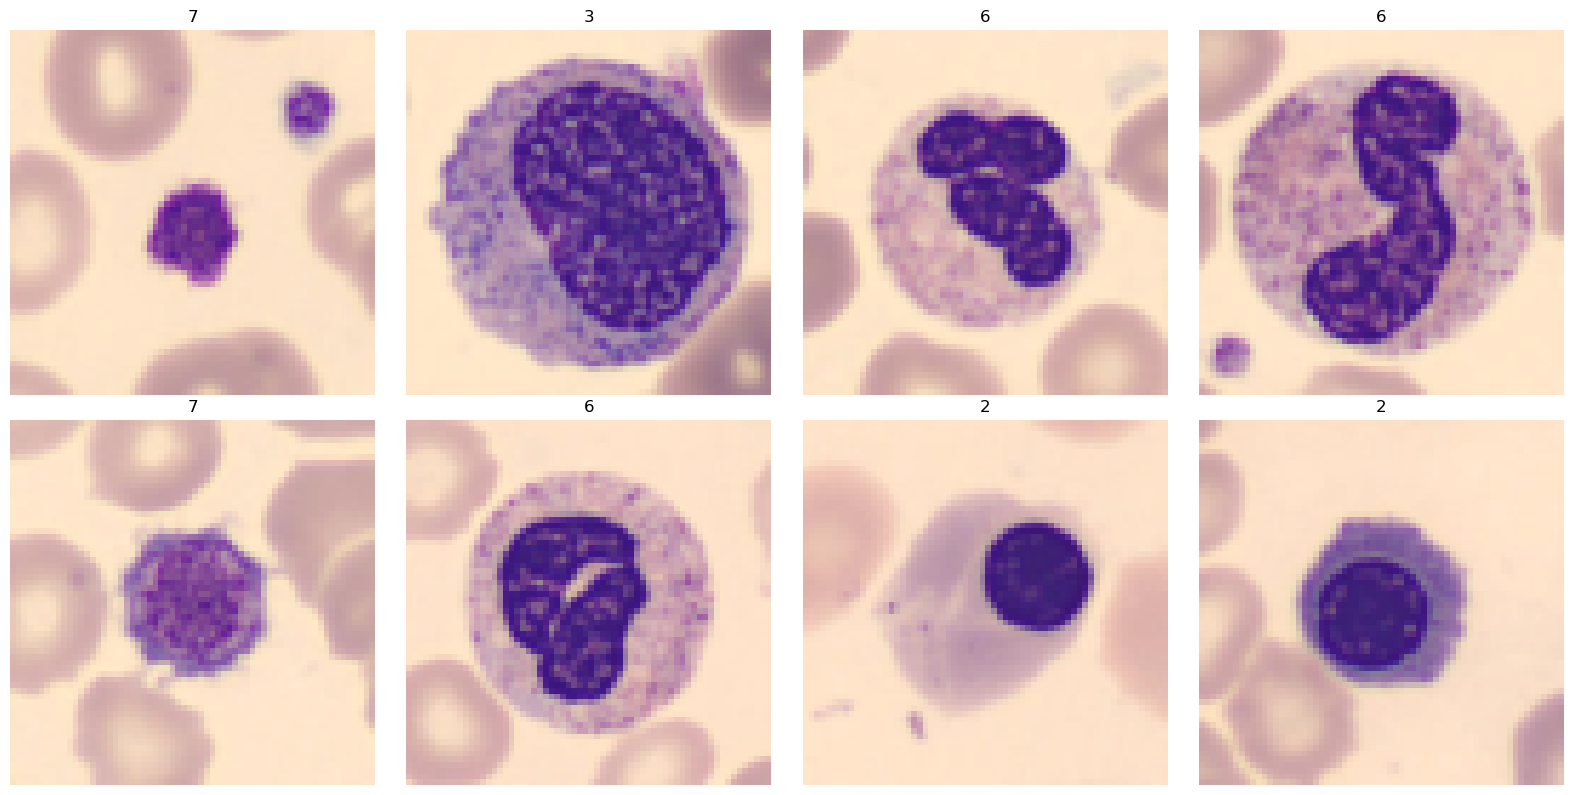

In [108]:
fig, axs = plt.subplots(2, 4, figsize=(16,8))
axs = axs.flatten()


for ax, label, image in zip(axs, blood_mnist64["train_labels"][:8], blood_mnist64["train_images"][:8]):
    ax.imshow(image)
    ax.set_title(label[0])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [109]:
train_ds, val_ds, test_ds = [bloodDataset(blood_mnist64[split+"_labels"], blood_mnist64[split+"_images"], transform=transforms.ToTensor()) for split in ["train", "val", "test"]]

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [110]:
model64 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(128*8*8, 128),
    nn.ReLU(),
    nn.Linear(128, 8)
).to(device)

In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model64.parameters(), lr=1e-3)

# num_epochs = 5

In [112]:
# 记录损失用于可视化
train_losses_blood64 = []
val_losses_blood64 = []

for epoch in range(num_epochs):
    model64.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model64(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses_blood64.append(train_loss)
    
    model64.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model64(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    val_loss /= len(val_loader)
    val_losses_blood64.append(val_loss)

    print(f"[{epoch+1}/{num_epochs}] train_loss: {train_loss:.6f} | val_loss: {val_loss:.6f}")

[1/10] train_loss: 0.990544 | val_loss: 0.739491
[2/10] train_loss: 0.447582 | val_loss: 0.351990
[3/10] train_loss: 0.343522 | val_loss: 0.280650
[4/10] train_loss: 0.276779 | val_loss: 0.236379
[5/10] train_loss: 0.231366 | val_loss: 0.181342
[6/10] train_loss: 0.190377 | val_loss: 0.184793
[7/10] train_loss: 0.146791 | val_loss: 0.191277
[8/10] train_loss: 0.128338 | val_loss: 0.183407
[9/10] train_loss: 0.104558 | val_loss: 0.160582
[10/10] train_loss: 0.086173 | val_loss: 0.142875


In [113]:
# 测试并收集预测概率用于AUC计算
model64.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model64(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
all_labels_array = np.array(all_labels)

In [114]:
f1 = f1_score(all_labels, all_preds, average="macro")
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f"Test F1 score: {f1:.6f}")

Test F1 score: 0.943093


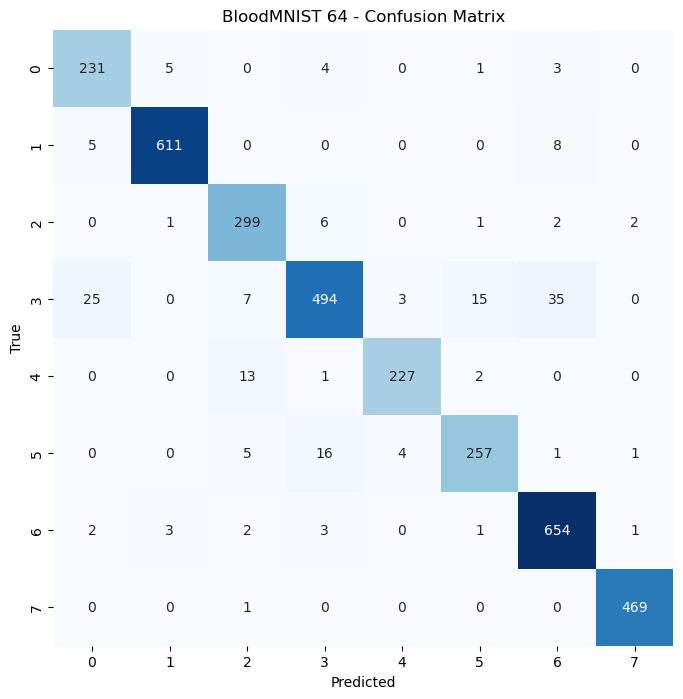

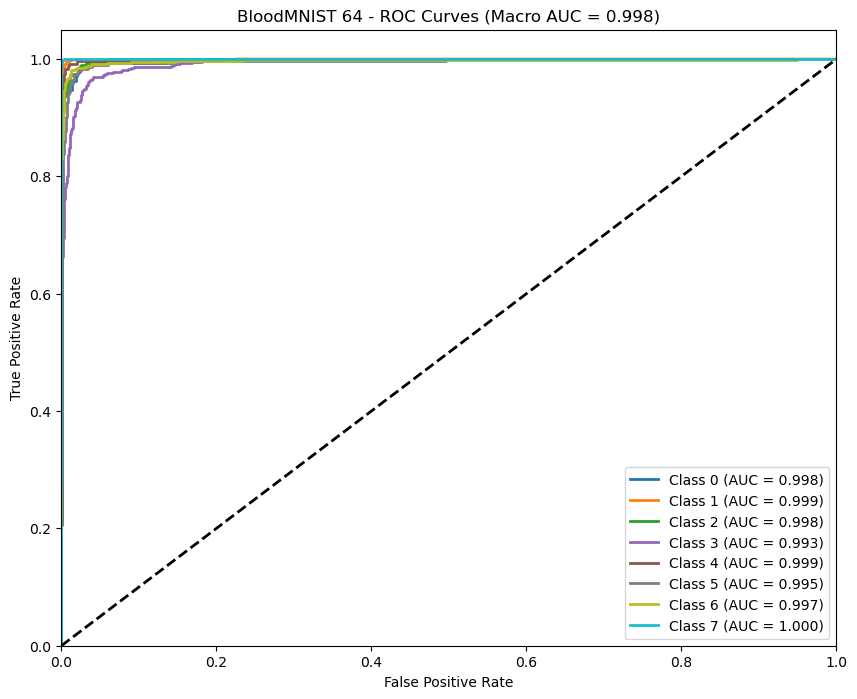

In [115]:
# 混淆矩阵
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("BloodMNIST 64 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 计算并绘制ROC曲线和AUC
n_classes = 8
labels_bin = label_binarize(all_labels_array, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算宏平均AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc_blood64 = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'BloodMNIST 64 - ROC Curves (Macro AUC = {macro_auc_blood64:.3f})')
plt.legend(loc="lower right")
plt.show()

# 保存结果
results['blood64'] = {
    'train_losses': train_losses_blood64,
    'val_losses': val_losses_blood64,
    'macro_auc': macro_auc_blood64,
    'fpr': all_fpr,
    'tpr': mean_tpr,
    'f1': f1
}

# OrgancMNIST 64

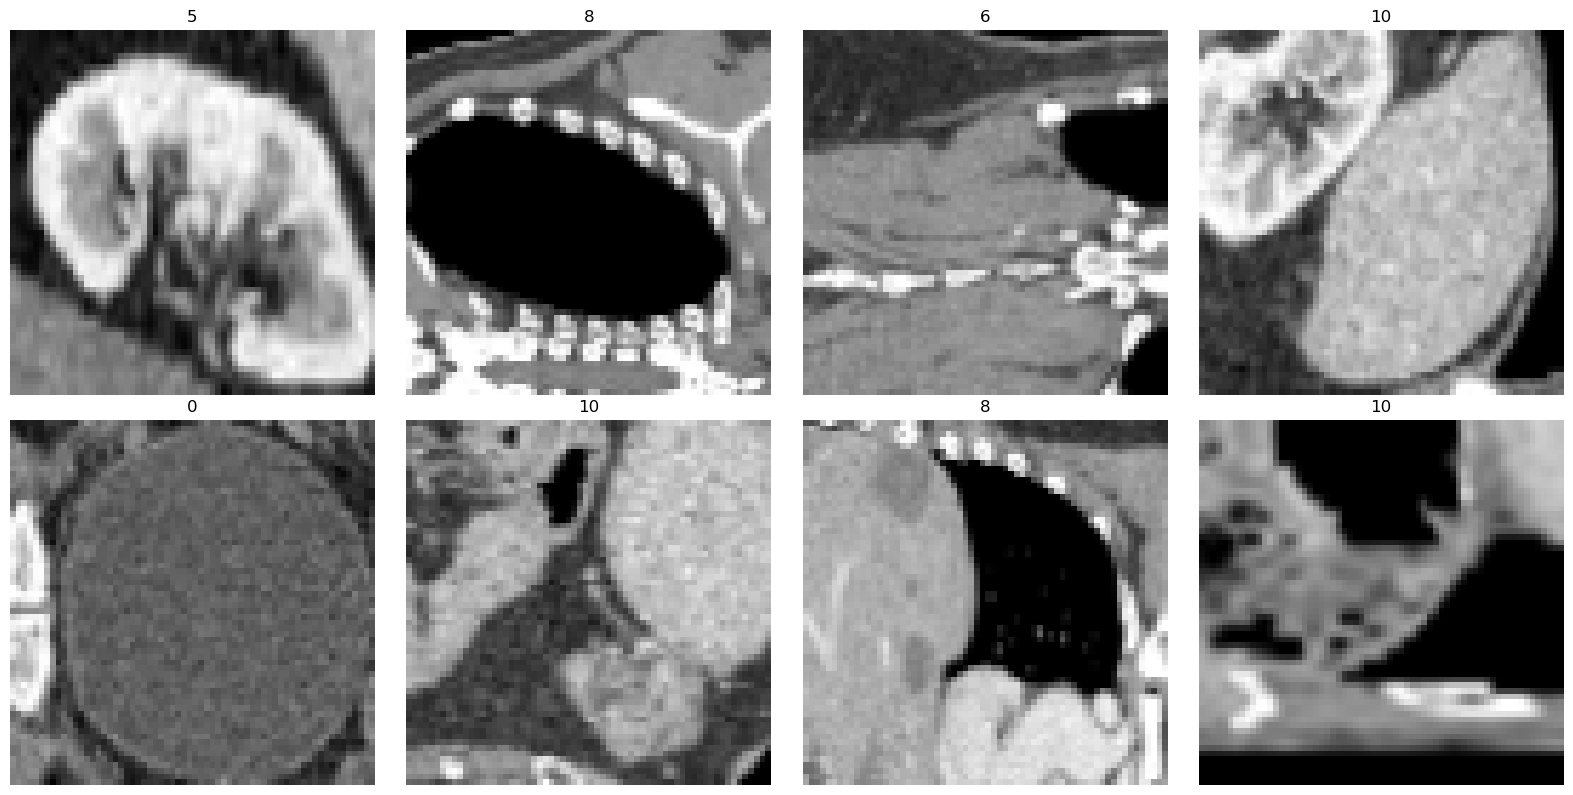

In [116]:
fig, axs = plt.subplots(2, 4, figsize=(16,8))
axs = axs.flatten()


for ax, label, image in zip(axs, organc_mnist64["train_labels"][:8], organc_mnist64["train_images"][:8]):
    ax.imshow(image, cmap="gray")
    ax.set_title(label[0])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [117]:
train_ds, val_ds, test_ds = [organcDataset(organc_mnist64[split+"_images"], organc_mnist64[split+"_labels"], transform=transforms.ToTensor()) for split in ["train", "val", "test"]]

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [118]:
organc_mnist64["train_images"][0].shape

(64, 64)

In [119]:
model64 = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    # nn.Conv2d(64, 128, kernel_size=3, padding=1),
    # nn.ReLU(),
    # nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(64*16*16, 128),
    nn.ReLU(),
    nn.Linear(128, 11)
).to(device)

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model64.parameters(), lr=1e-3)
# num_epochs = 5

In [121]:
# 记录损失用于可视化
train_losses_organc64 = []
val_losses_organc64 = []

for epoch in range(num_epochs):
    model64.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model64(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses_organc64.append(train_loss)
    
    model64.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model64(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    val_loss /= len(val_loader)
    val_losses_organc64.append(val_loss)

    print(f"[{epoch+1}/{num_epochs}] train_loss: {train_loss:.6f} | val_loss: {val_loss:.6f}")

[1/10] train_loss: 0.594551 | val_loss: 0.233561
[2/10] train_loss: 0.201119 | val_loss: 0.168205
[3/10] train_loss: 0.120149 | val_loss: 0.186337
[4/10] train_loss: 0.079027 | val_loss: 0.191758
[5/10] train_loss: 0.053209 | val_loss: 0.291150
[6/10] train_loss: 0.040173 | val_loss: 0.293779
[7/10] train_loss: 0.031032 | val_loss: 0.381523
[8/10] train_loss: 0.031139 | val_loss: 0.298520
[9/10] train_loss: 0.015874 | val_loss: 0.291525
[10/10] train_loss: 0.028672 | val_loss: 0.225147


In [122]:
# 测试并收集预测概率用于AUC计算
model64.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model64(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
all_labels_array = np.array(all_labels)

In [123]:
f1 = f1_score(all_labels, all_preds, average="macro")
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f"Test F1 score: {f1:.6f}")

Test F1 score: 0.864789


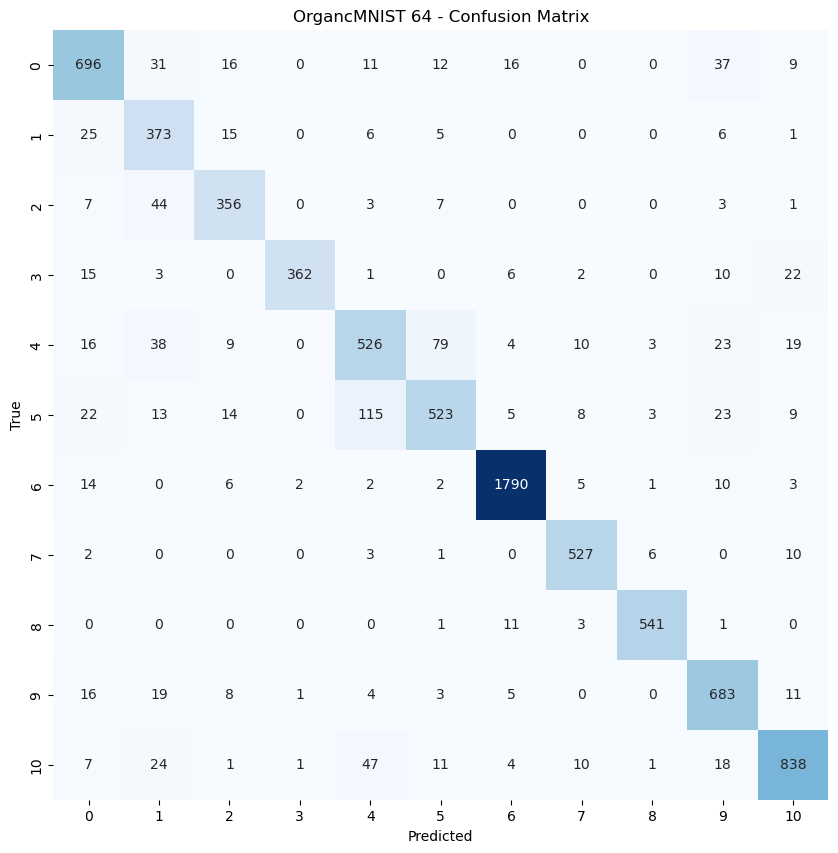

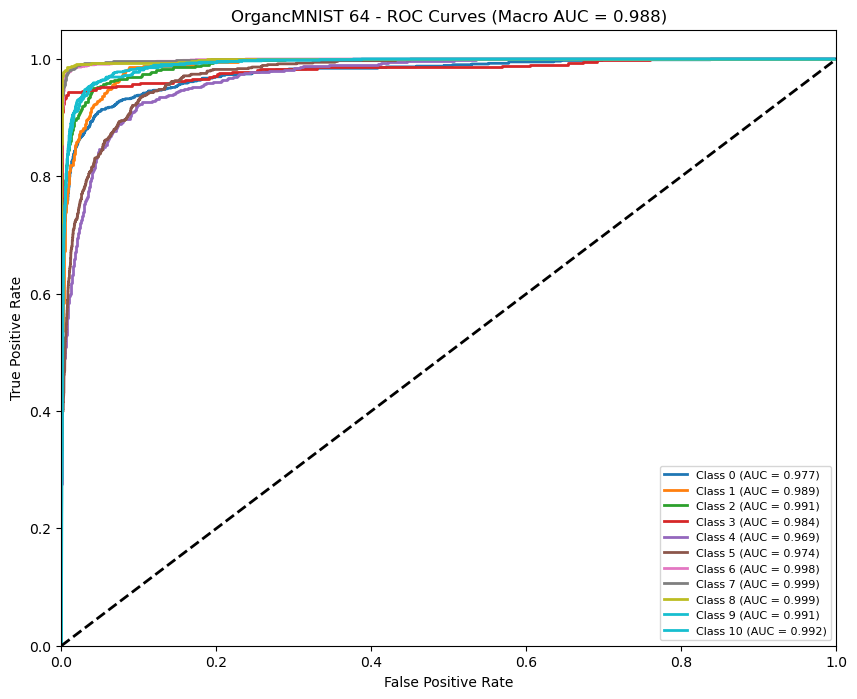

In [124]:
# 混淆矩阵
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("OrgancMNIST 64 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 计算并绘制ROC曲线和AUC
n_classes = 11
labels_bin = label_binarize(all_labels_array, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算宏平均AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc_organc64 = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'OrgancMNIST 64 - ROC Curves (Macro AUC = {macro_auc_organc64:.3f})')
plt.legend(loc="lower right", fontsize=8)
plt.show()

# 保存结果
results['organc64'] = {
    'train_losses': train_losses_organc64,
    'val_losses': val_losses_organc64,
    'macro_auc': macro_auc_organc64,
    'fpr': all_fpr,
    'tpr': mean_tpr,
    'f1': f1
}

# 实验结果对比分析

C:\Users\SIRB-M\AppData\Local\Temp\ipykernel_14340\1161494857.py:42: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  plt.savefig('loss_curves_comparison.png', dpi=150, bbox_inches='tight')
C:\Users\SIRB-M\AppData\Local\Temp\ipykernel_14340\1161494857.py:42: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  plt.savefig('loss_curves_comparison.png', dpi=150, bbox_inches='tight')
C:\Users\SIRB-M\AppData\Local\Temp\ipykernel_14340\1161494857.py:42: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.savefig('loss_curves_comparison.png', dpi=150, bbox_inches='tight')
C:\Users\SIRB-M\AppData\Local\Temp\ipykernel_14340\1161494857.py:42: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.savefig('loss_curves_comparison.png', dpi=150, bbox_inches='tight')
C:\Users\SIRB-M\AppData\Local\Temp\ipykernel_14340\116149485

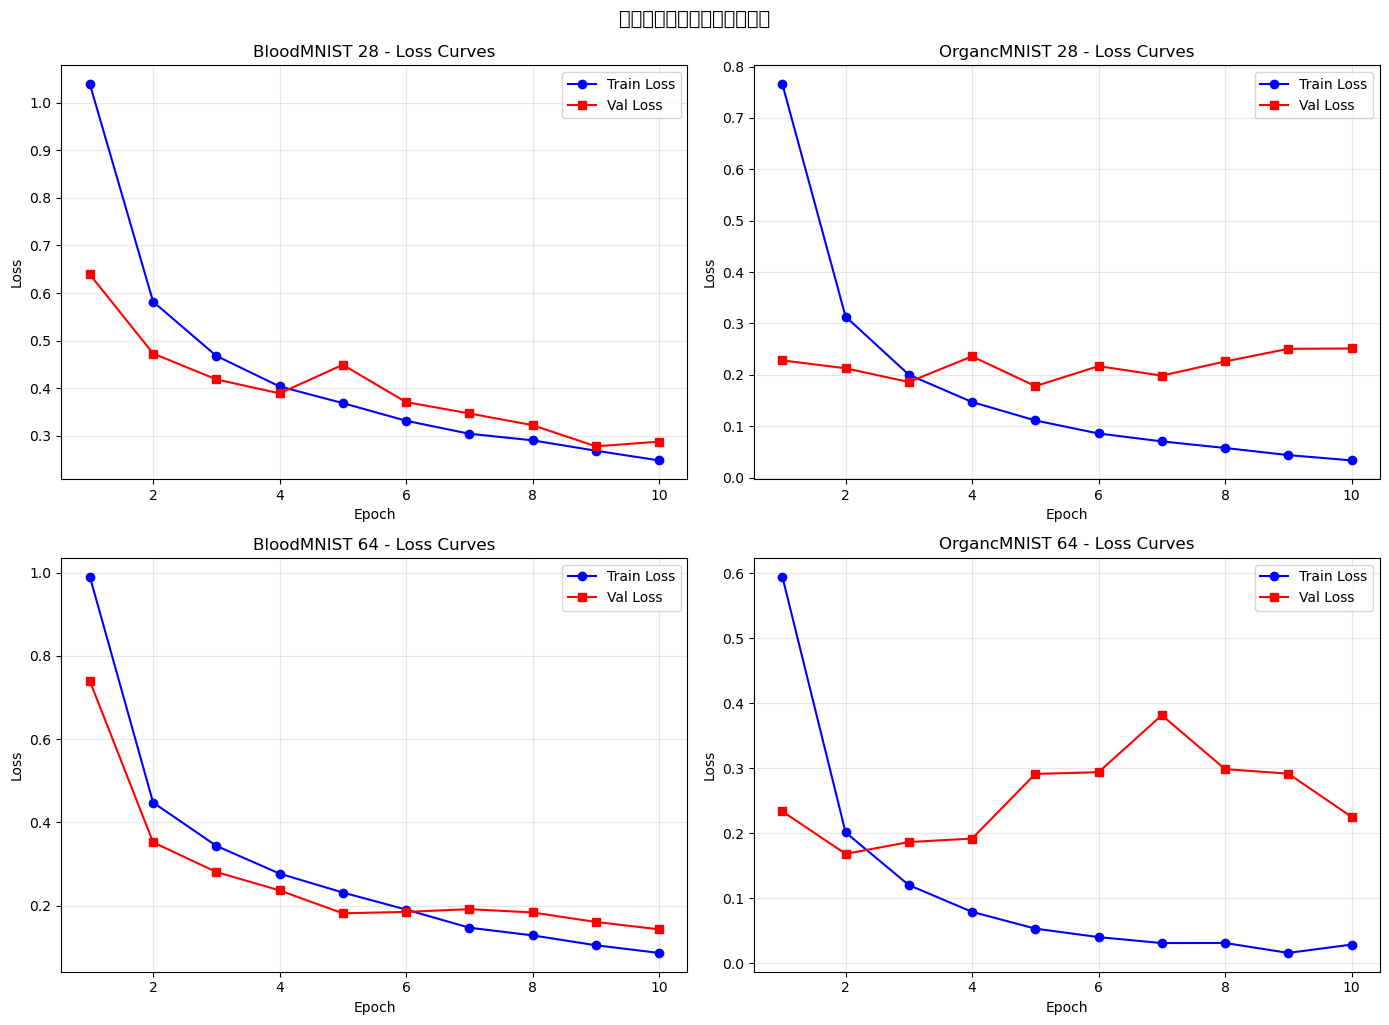

In [125]:
# ==================== 损失函数可视化 ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# BloodMNIST 28 损失曲线
axes[0, 0].plot(range(1, num_epochs+1), results['blood28']['train_losses'], 'b-', label='Train Loss', marker='o')
axes[0, 0].plot(range(1, num_epochs+1), results['blood28']['val_losses'], 'r-', label='Val Loss', marker='s')
axes[0, 0].set_title('BloodMNIST 28 - Loss Curves')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# OrgancMNIST 28 损失曲线
axes[0, 1].plot(range(1, num_epochs+1), results['organc28']['train_losses'], 'b-', label='Train Loss', marker='o')
axes[0, 1].plot(range(1, num_epochs+1), results['organc28']['val_losses'], 'r-', label='Val Loss', marker='s')
axes[0, 1].set_title('OrgancMNIST 28 - Loss Curves')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# BloodMNIST 64 损失曲线
axes[1, 0].plot(range(1, num_epochs+1), results['blood64']['train_losses'], 'b-', label='Train Loss', marker='o')
axes[1, 0].plot(range(1, num_epochs+1), results['blood64']['val_losses'], 'r-', label='Val Loss', marker='s')
axes[1, 0].set_title('BloodMNIST 64 - Loss Curves')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# OrgancMNIST 64 损失曲线
axes[1, 1].plot(range(1, num_epochs+1), results['organc64']['train_losses'], 'b-', label='Train Loss', marker='o')
axes[1, 1].plot(range(1, num_epochs+1), results['organc64']['val_losses'], 'r-', label='Val Loss', marker='s')
axes[1, 1].set_title('OrgancMNIST 64 - Loss Curves')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('四个实验的损失函数曲线对比', y=1.02, fontsize=14)
plt.savefig('loss_curves_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

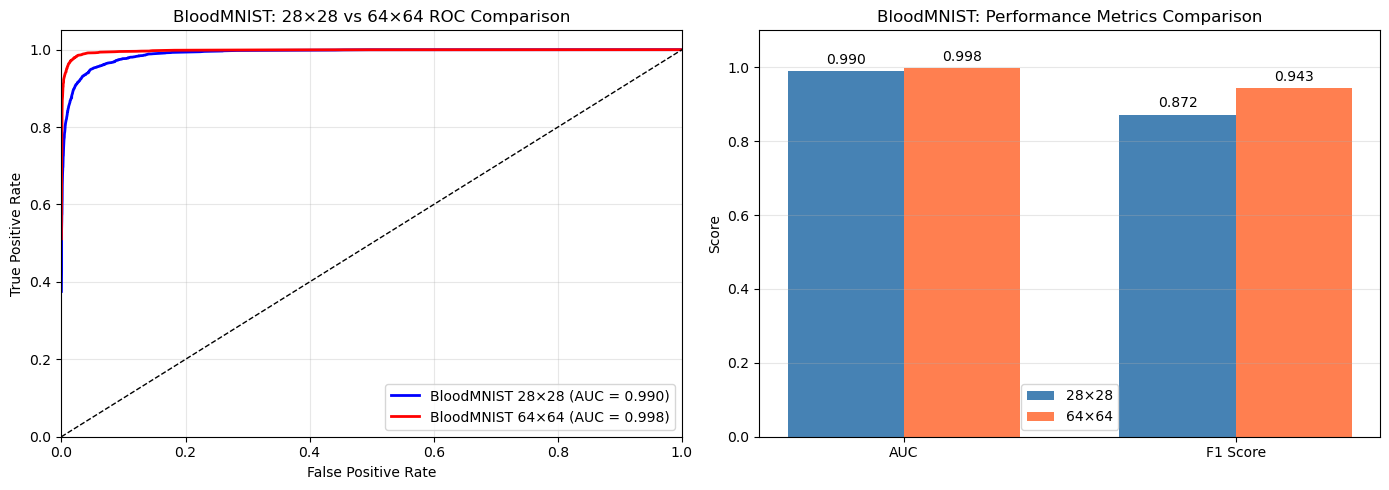

In [126]:
# ==================== 血细胞(BloodMNIST)不同分辨率AUC对比 ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：BloodMNIST 28 vs 64 ROC曲线对比
axes[0].plot(results['blood28']['fpr'], results['blood28']['tpr'], 'b-', lw=2, 
             label=f'BloodMNIST 28×28 (AUC = {results["blood28"]["macro_auc"]:.3f})')
axes[0].plot(results['blood64']['fpr'], results['blood64']['tpr'], 'r-', lw=2,
             label=f'BloodMNIST 64×64 (AUC = {results["blood64"]["macro_auc"]:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('BloodMNIST: 28×28 vs 64×64 ROC Comparison')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# 右图：柱状图对比
metrics = ['AUC', 'F1 Score']
blood28_vals = [results['blood28']['macro_auc'], results['blood28']['f1']]
blood64_vals = [results['blood64']['macro_auc'], results['blood64']['f1']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1].bar(x - width/2, blood28_vals, width, label='28×28', color='steelblue')
bars2 = axes[1].bar(x + width/2, blood64_vals, width, label='64×64', color='coral')

axes[1].set_ylabel('Score')
axes[1].set_title('BloodMNIST: Performance Metrics Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(True, alpha=0.3, axis='y')

# 添加数值标签
for bar in bars1:
    height = bar.get_height()
    axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.savefig('blood_mnist_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

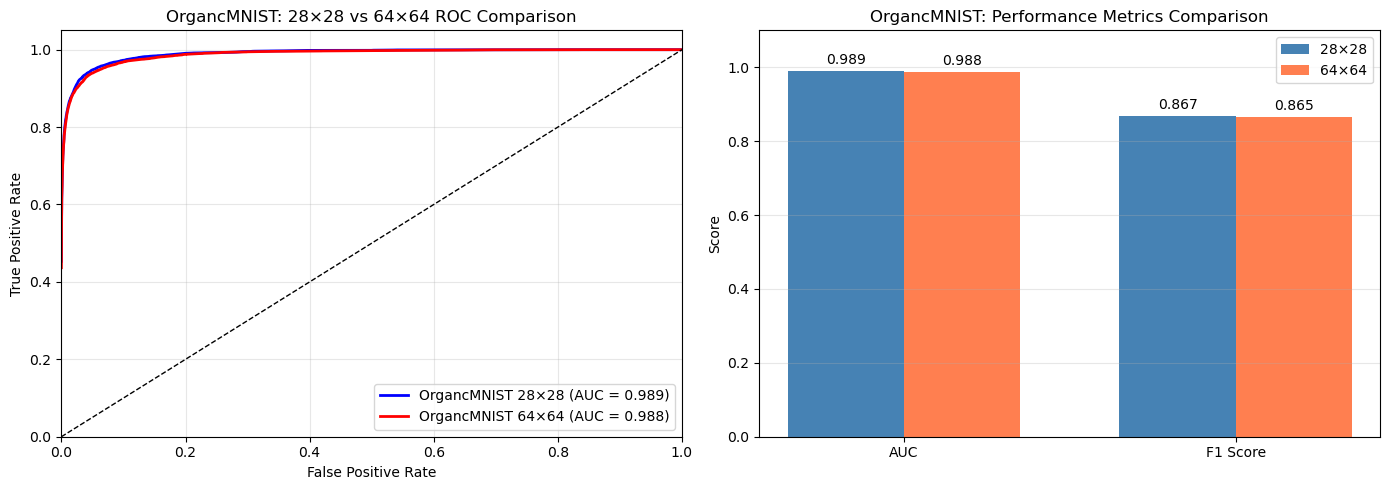

In [127]:
# ==================== 器官(OrgancMNIST)不同分辨率AUC对比 ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：OrgancMNIST 28 vs 64 ROC曲线对比
axes[0].plot(results['organc28']['fpr'], results['organc28']['tpr'], 'b-', lw=2, 
             label=f'OrgancMNIST 28×28 (AUC = {results["organc28"]["macro_auc"]:.3f})')
axes[0].plot(results['organc64']['fpr'], results['organc64']['tpr'], 'r-', lw=2,
             label=f'OrgancMNIST 64×64 (AUC = {results["organc64"]["macro_auc"]:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('OrgancMNIST: 28×28 vs 64×64 ROC Comparison')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# 右图：柱状图对比
metrics = ['AUC', 'F1 Score']
organc28_vals = [results['organc28']['macro_auc'], results['organc28']['f1']]
organc64_vals = [results['organc64']['macro_auc'], results['organc64']['f1']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1].bar(x - width/2, organc28_vals, width, label='28×28', color='steelblue')
bars2 = axes[1].bar(x + width/2, organc64_vals, width, label='64×64', color='coral')

axes[1].set_ylabel('Score')
axes[1].set_title('OrgancMNIST: Performance Metrics Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(True, alpha=0.3, axis='y')

# 添加数值标签
for bar in bars1:
    height = bar.get_height()
    axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.savefig('organc_mnist_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

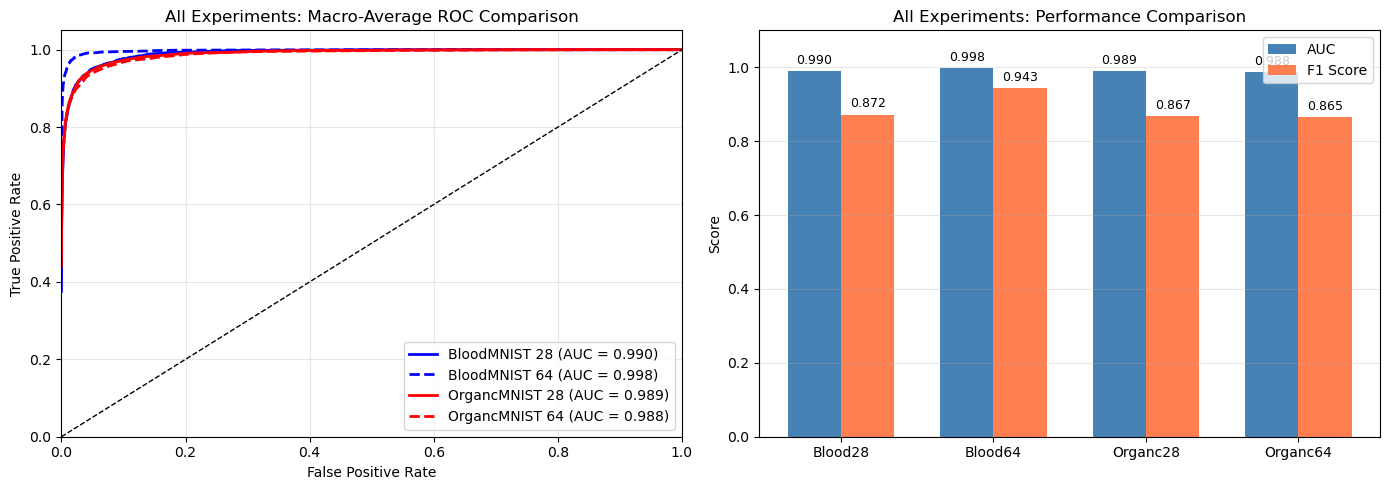


实验结果汇总
实验                   Macro AUC       F1 Score       
------------------------------------------------------------
BloodMNIST 28×28     0.9904          0.8721         
BloodMNIST 64×64     0.9976          0.9431         
OrgancMNIST 28×28    0.9893          0.8671         
OrgancMNIST 64×64    0.9876          0.8648         


In [128]:
# ==================== 四个实验综合对比 ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：所有实验的ROC曲线对比
axes[0].plot(results['blood28']['fpr'], results['blood28']['tpr'], 'b-', lw=2, 
             label=f'BloodMNIST 28 (AUC = {results["blood28"]["macro_auc"]:.3f})')
axes[0].plot(results['blood64']['fpr'], results['blood64']['tpr'], 'b--', lw=2,
             label=f'BloodMNIST 64 (AUC = {results["blood64"]["macro_auc"]:.3f})')
axes[0].plot(results['organc28']['fpr'], results['organc28']['tpr'], 'r-', lw=2, 
             label=f'OrgancMNIST 28 (AUC = {results["organc28"]["macro_auc"]:.3f})')
axes[0].plot(results['organc64']['fpr'], results['organc64']['tpr'], 'r--', lw=2,
             label=f'OrgancMNIST 64 (AUC = {results["organc64"]["macro_auc"]:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('All Experiments: Macro-Average ROC Comparison')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# 右图：所有实验的性能指标柱状图
experiments = ['Blood28', 'Blood64', 'Organc28', 'Organc64']
auc_values = [results['blood28']['macro_auc'], results['blood64']['macro_auc'],
              results['organc28']['macro_auc'], results['organc64']['macro_auc']]
f1_values = [results['blood28']['f1'], results['blood64']['f1'],
             results['organc28']['f1'], results['organc64']['f1']]

x = np.arange(len(experiments))
width = 0.35

bars1 = axes[1].bar(x - width/2, auc_values, width, label='AUC', color='steelblue')
bars2 = axes[1].bar(x + width/2, f1_values, width, label='F1 Score', color='coral')

axes[1].set_ylabel('Score')
axes[1].set_title('All Experiments: Performance Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(experiments)
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(True, alpha=0.3, axis='y')

# 添加数值标签
for bar in bars1:
    height = bar.get_height()
    axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    axes[1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('all_experiments_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印结果汇总表
print("\n" + "="*60)
print("实验结果汇总")
print("="*60)
print(f"{'实验':<20} {'Macro AUC':<15} {'F1 Score':<15}")
print("-"*60)
for name, key in [('BloodMNIST 28×28', 'blood28'), ('BloodMNIST 64×64', 'blood64'),
                  ('OrgancMNIST 28×28', 'organc28'), ('OrgancMNIST 64×64', 'organc64')]:
    print(f"{name:<20} {results[key]['macro_auc']:<15.4f} {results[key]['f1']:<15.4f}")
print("="*60)